In [ ]:
%pip install beautifulsoup4

In [1]:
from bs4 import BeautifulSoup
import requests

In [84]:
html_text = requests.get('https://www.airlinequality.com/airline-reviews/british-airways/page/7/?sortby=post_date%3ADesc&pagesize=100', timeout=5).text
#print(html_text)
soup = BeautifulSoup(html_text, 'lxml')
reviews = soup.find_all('article', class_ = 'comp_media-review-rated')

In [ ]:
print(reviews)

In [74]:
review = soup.find('article', class_ = 'comp_media-review-rated')
#print(review)

In [183]:
print(review.find('span', itemprop = 'name'))

<span itemprop="name">Ray Desjardins</span>


In [205]:
html_text = requests.get('https://www.airlinequality.com/airline-reviews/british-airways/page/39/?sortby=post_date%3ADesc&pagesize=100', timeout=5).text
#print(html_text)
soup = BeautifulSoup(html_text, 'lxml')
reviews = soup.find_all('article', class_ = 'comp_media-review-rated')

In [206]:
import csv

# Open a CSV file for writing
with open('airline_reviews.csv', mode='a', newline='', encoding='utf-8') as file:
    # Define the column headers
    writer = csv.writer(file)
    #writer.writerow(['Airline Rating', 'Review Name', 'Review Head', 'Review Content', 'Review Date', 'Recommended', 'Seat Comfort', 'Cabin Staff Service', 'Food & Beverages', 'Inflight Entertainment', 'Ground Service', 'Value For Money'])

    # Iterate through the reviews
    for review in reviews:
        rating_element = review.find('span', itemprop='ratingValue')
        airline_rating = rating_element.text if rating_element is not None else None
        review_name = review.find('span', itemprop="name").text
        review_head = review.find('h2', class_="text_header").text
        review_content = review.find('div', class_="text_content").text[20:]
        review_date = review.find('time', itemprop="datePublished").get('datetime')

        # Extract ratings for categories
        ratings = {}
        rows = review.find_all('tr')
        for row in rows:
            header = row.find('td', class_='review-rating-header')  # Find the header
            stars = row.find_all('span', class_='star fill')  # Find all filled stars
            if header and stars:
                header_text = header.get_text(strip=True)  # Get the text of the header
                filled_star_count = len(stars)  # Count the filled stars
                ratings[header_text] = filled_star_count

        # Get 'Recommended' status
        recommended_header = review.find('td', class_='review-rating-header recommended')
        recommended_value = review.find('td', class_='review-value rating-yes')
        recommended = 'Yes' if recommended_value else 'No'

        # Collect all the data into a list (for writing a row in CSV)
        row_data = [
            airline_rating,
            review_name,
            review_head,
            review_content,
            review_date,
            recommended,  # Add 'Yes' or 'No' for Recommended
            ratings.get('Seat Comfort', ''),  # Get the rating for Seat Comfort or empty if not available
            ratings.get('Cabin Staff Service', ''),
            ratings.get('Food & Beverages', ''),
            ratings.get('Inflight Entertainment', ''),
            ratings.get('Ground Service', ''),
            ratings.get('Value For Money', '')
        ]

        # Write the row to the CSV
        writer.writerow(row_data)


Text Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('airline_reviews.csv')

In [3]:
df = df.drop_duplicates()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3857 entries, 0 to 3956
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Rating          3852 non-null   float64
 1   Review Name             3857 non-null   object 
 2   Review Head             3857 non-null   object 
 3   Review Content          3857 non-null   object 
 4   Review Date             3857 non-null   object 
 5   Recommended             3857 non-null   object 
 6   Seat Comfort            3732 non-null   float64
 7   Cabin Staff Service     3717 non-null   float64
 8   Food & Beverages        3430 non-null   float64
 9   Inflight Entertainment  2628 non-null   float64
 10  Ground Service          3015 non-null   float64
 11  Value For Money         3856 non-null   float64
dtypes: float64(7), object(5)
memory usage: 391.7+ KB


Handle Missing Values

In [5]:
df_cleaned = df.dropna(subset=['Airline Rating','Value For Money'])

In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3851 entries, 0 to 3956
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Rating          3851 non-null   float64
 1   Review Name             3851 non-null   object 
 2   Review Head             3851 non-null   object 
 3   Review Content          3851 non-null   object 
 4   Review Date             3851 non-null   object 
 5   Recommended             3851 non-null   object 
 6   Seat Comfort            3726 non-null   float64
 7   Cabin Staff Service     3711 non-null   float64
 8   Food & Beverages        3424 non-null   float64
 9   Inflight Entertainment  2622 non-null   float64
 10  Ground Service          3015 non-null   float64
 11  Value For Money         3851 non-null   float64
dtypes: float64(7), object(5)
memory usage: 391.1+ KB


In [7]:
columns_to_impute = ['Seat Comfort', 'Cabin Staff Service', 'Food & Beverages','Inflight Entertainment','Ground Service']

grouped = df_cleaned.groupby('Airline Rating')[columns_to_impute].mean().round(0)

In [8]:
grouped

,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service
Airline Rating,,,,,
1.0,2.0,2.0,2.0,2.0,1.0
2.0,2.0,2.0,2.0,2.0,2.0
3.0,2.0,3.0,2.0,2.0,2.0
4.0,3.0,3.0,2.0,2.0,3.0
5.0,3.0,3.0,2.0,2.0,3.0
6.0,3.0,4.0,3.0,3.0,3.0
7.0,3.0,4.0,3.0,3.0,4.0
8.0,4.0,4.0,4.0,3.0,4.0
9.0,4.0,5.0,4.0,4.0,4.0


In [9]:
for cols in columns_to_impute:
    df_cleaned[cols] = df_cleaned[cols].fillna(df_cleaned.groupby('Airline Rating')[cols].transform('mean').round(0))

C:\Users\Mrudula\AppData\Local\Temp\ipykernel_6116\754999911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[cols] = df_cleaned[cols].fillna(df_cleaned.groupby('Airline Rating')[cols].transform('mean').round(0))
C:\Users\Mrudula\AppData\Local\Temp\ipykernel_6116\754999911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[cols] = df_cleaned[cols].fillna(df_cleaned.groupby('Airline Rating')[cols].transform('mean').round(0))
C:\Users\Mrudula\AppData\Local\Temp\ipykernel_6116\7549999

In [10]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3851 entries, 0 to 3956
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Airline Rating          3851 non-null   float64
 1   Review Name             3851 non-null   object 
 2   Review Head             3851 non-null   object 
 3   Review Content          3851 non-null   object 
 4   Review Date             3851 non-null   object 
 5   Recommended             3851 non-null   object 
 6   Seat Comfort            3851 non-null   float64
 7   Cabin Staff Service     3851 non-null   float64
 8   Food & Beverages        3851 non-null   float64
 9   Inflight Entertainment  3851 non-null   float64
 10  Ground Service          3851 non-null   float64
 11  Value For Money         3851 non-null   float64
dtypes: float64(7), object(5)
memory usage: 391.1+ KB


In [11]:
df_text = pd.DataFrame(df_cleaned[['Airline Rating','Review Content']])

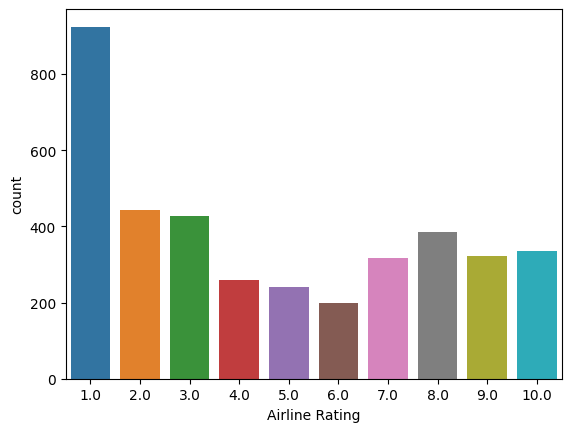

In [12]:
df_text['Airline Rating'].value_counts()
sns.countplot(x='Airline Rating', data= df_text)
plt.show()

In [13]:
def assign_sentiment(rating):
    if rating >= 7.0:
        return 2
    elif rating <= 2:
        return 0
    else:
        return 1

# Apply the function to the 'Airline Rating' column
df_text['Sentiment'] = df_text['Airline Rating'].apply(assign_sentiment)

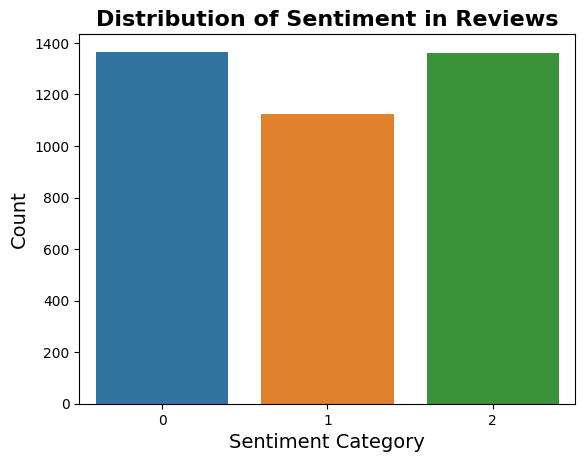

In [53]:
sns.countplot(x='Sentiment', data= df_text)
plt.title('Distribution of Sentiment in Reviews', fontsize=16, weight='bold')
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [15]:
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [16]:
df_text['Text'] = df_text['Review Content'].astype('str').apply(simplify)

In [17]:
import re
df_text['Text'] = df_text['Text'].apply(lambda x: x.strip().replace('\n', ' ').replace('\r', ' '))
df_text['Text'] = df_text['Text'].apply(lambda x: re.sub(r'&#039;', '\'', x))
df_text['Text'] = df_text['Text'].apply(lambda x: re.sub(r'&[^;]*;', '', x))
df_text['Text'] = df_text['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\'\.\,]', ' ', x)).apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))
df_text['Text'] = df_text['Text'].apply(lambda x: re.sub(r'http\S+', '', x))
df_text['Text'] = df_text['Text'].replace(r'@\w+','',regex=True)

In [18]:
def convert_to_lower(text):
    return text.lower()
df_text['Text'] = df_text['Text'].apply(lambda x: convert_to_lower(x))

In [19]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=True)
df_text['Tokenized_tweet'] = df_text['Text'].apply(tokenizer.tokenize)

In [20]:
df_text

,Airline Rating,Review Content,Sentiment,Text,Tokenized_tweet
0,5.0,British Airways World Traveller Plus (Premium ...,1,british airways world traveller plus premium ...,"[british, airways, world, traveller, plus, pre..."
1,2.0,BA is barely a step above low cost airlines. T...,0,ba is barely a step above low cost airlines. t...,"[ba, is, barely, a, step, above, low, cost, ai..."
2,10.0,y with the flight crew. Hadn't been on a plane...,2,y with the flight crew. hadn't been on a plane...,"[y, with, the, flight, crew, ., hadn't, been, ..."
3,1.0,Horrible service from boarding to landing. I f...,0,horrible service from boarding to landing. i f...,"[horrible, service, from, boarding, to, landin..."
4,1.0,ife and I are very disappointed with flying on...,0,ife and i are very disappointed with flying on...,"[ife, and, i, are, very, disappointed, with, f..."
...,...,...,...,...,...
3952,4.0,7 - 23/08/12. Much has been written about the ...,1,. much has been written about the ...,"[., much, has, been, written, about, the, tire..."
3953,9.0,ddresses all club passengers by name boarding ...,2,ddresses all club passengers by name boarding ...,"[ddresses, all, club, passengers, by, name, bo..."
3954,5.0,d for British Airways urged me to fly British ...,1,d for british airways urged me to fly british ...,"[d, for, british, airways, urged, me, to, fly,..."
3955,4.0,JFK via Shannon on A318 but had really nice s...,1,jfk via shannon on a but had really nice se...,"[jfk, via, shannon, on, a, but, had, really, n..."


Remove stopwords

In [45]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
def remove_stopwords(text):

    clean_text = [word for word in text if not word in stop_words ]
    return clean_text  

In [46]:
df_text['Clean_text'] = df_text['Tokenized_tweet'].apply(remove_stopwords)

In [47]:
df_text['Clean_text'] = df_text['Clean_text'].str.join(' ')

Lemmatize

In [24]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Download necessary NLTK data files
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional: for additional language support
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mrudula\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mrudula\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mrudula\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mrudula\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Mrudula\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [25]:
from nltk.tag import pos_tag
def get_wordnet_pos(treebank_tag):
    """Convert treebank POS tags to WordNet POS tags."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if POS is unknown

def lemmatize_sentence(sentence):
    # Tokenize the sentence
    words = nltk.word_tokenize(sentence)
    # Get POS tags for each word
    pos_tags = pos_tag(words)
    # Lemmatize each word with the correct POS tag
    lemmatized_sentence = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_sentence)

In [26]:
df_text['Lemmatized_Text'] = df_text['Clean_text'].apply(lemmatize_sentence)

In [27]:
from textblob import TextBlob

def spell_check(text):
   
    txtblob = TextBlob(text)
    corrected_text = txtblob.correct()
    return str(corrected_text)

In [28]:
df_text['Cleaner_Textt'] = df_text['Lemmatized_Text'].astype('str').apply(lambda x: spell_check(x))

In [29]:
df_text

,Airline Rating,Review Content,Sentiment,Text,Tokenized_tweet,Clean_text,Lemmatized_Text,Cleaner_Textt
0,5.0,British Airways World Traveller Plus (Premium ...,1,british airways world traveller plus premium ...,"[british, airways, world, traveller, plus, pre...",british airways world traveller plus premium e...,british airway world traveller plus premium ec...,british away world traveller plus premium econ...
1,2.0,BA is barely a step above low cost airlines. T...,0,ba is barely a step above low cost airlines. t...,"[ba, is, barely, a, step, above, low, cost, ai...",ba barely step low cost airlines . try dime ni...,ba barely step low cost airline . try dime nic...,ba barely step low cost airline . try time nic...
2,10.0,y with the flight crew. Hadn't been on a plane...,2,y with the flight crew. hadn't been on a plane...,"[y, with, the, flight, crew, ., hadn't, been, ...",flight crew . plane years stressed . made comf...,flight crew . plane year stress . make comfort...,flight crew . plane year stress . make comfort...
3,1.0,Horrible service from boarding to landing. I f...,0,horrible service from boarding to landing. i f...,"[horrible, service, from, boarding, to, landin...",horrible service boarding landing . flew londo...,horrible service board land . flew london marr...,horrible service board land . flew london marr...
4,1.0,ife and I are very disappointed with flying on...,0,ife and i are very disappointed with flying on...,"[ife, and, i, are, very, disappointed, with, f...",ife disappointed flying british airways . flig...,ife disappoint fly british airway . flight can...,if disappoint fly british away . flight cancel...
...,...,...,...,...,...,...,...,...
3952,4.0,7 - 23/08/12. Much has been written about the ...,1,. much has been written about the ...,"[., much, has, been, written, about, the, tire...",. much written tired old fleet go . annoying r...,. much write tired old fleet go . annoy row fr...,. much write tired old fleet go . annoy row fr...
3953,9.0,ddresses all club passengers by name boarding ...,2,ddresses all club passengers by name boarding ...,"[ddresses, all, club, passengers, by, name, bo...",ddresses club passengers name boarding little ...,ddresses club passenger name board little late...,dresses club passenger name board little late ...
3954,5.0,d for British Airways urged me to fly British ...,1,d for british airways urged me to fly british ...,"[d, for, british, airways, urged, me, to, fly,...",british airways urged fly british airways kans...,british airway urge fly british airway kansas ...,british away urge fly british away kansas city...
3955,4.0,JFK via Shannon on A318 but had really nice s...,1,jfk via shannon on a but had really nice se...,"[jfk, via, shannon, on, a, but, had, really, n...",jfk via shannon really nice seats professional...,jfk via shannon really nice seat professional ...,of via cannon really nice seat professional cr...


Word Cloud

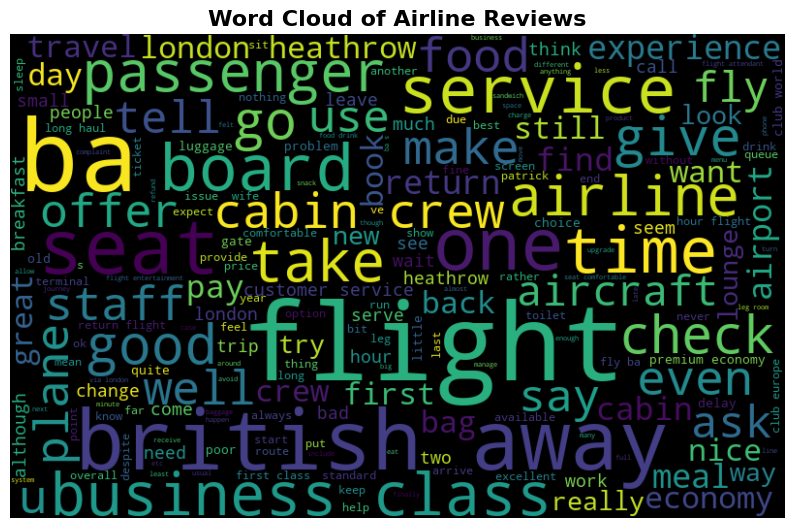

In [54]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

normal_words =' '.join([text for text in df_text['Cleaner_Textt']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Airline Reviews', fontsize=16, weight='bold')
plt.axis('off')
plt.show()


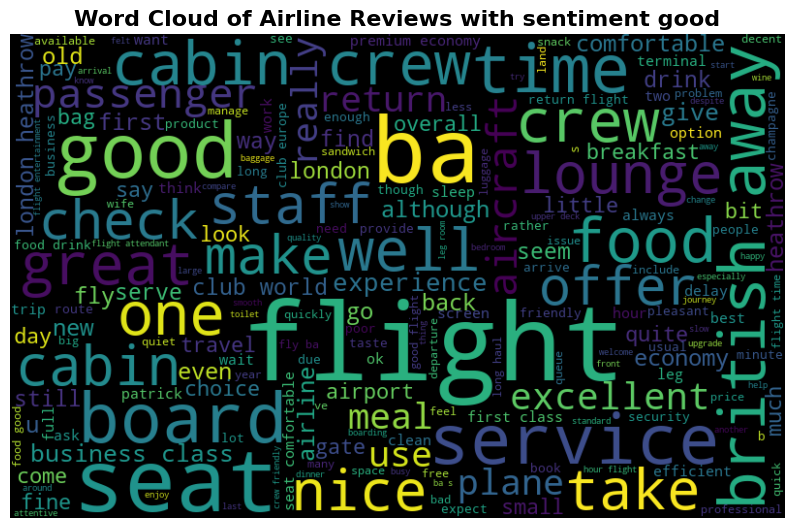

In [55]:
normal_words =' '.join([text for text in df_text['Cleaner_Textt'][df_text['Sentiment'] == 2]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Airline Reviews with sentiment good', fontsize=16, weight='bold')
plt.axis('off')
plt.show()

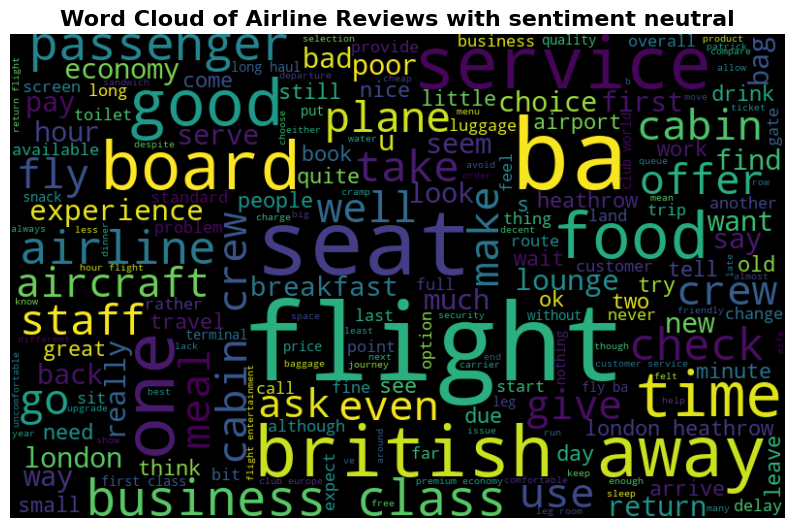

In [56]:
normal_words =' '.join([text for text in df_text['Cleaner_Textt'][df_text['Sentiment'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Airline Reviews with sentiment neutral', fontsize=16, weight='bold')
plt.axis('off')
plt.show()

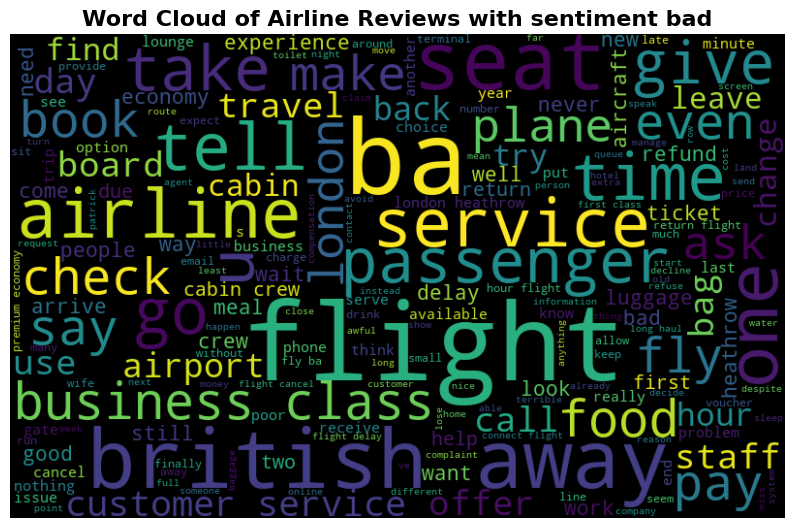

In [57]:
normal_words =' '.join([text for text in df_text['Cleaner_Textt'][df_text['Sentiment'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Airline Reviews with sentiment bad', fontsize=16, weight='bold')
plt.axis('off')
plt.show()

In [48]:
X = df_text['Cleaner_Textt']
y = df_text['Sentiment']

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

count_vect = CountVectorizer(ngram_range=(1, 2))
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

X_counts = count_vect.fit_transform(X)
X_tfidf = transformer.fit_transform(X_counts)

In [50]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [51]:
from sklearn.linear_model import LogisticRegression
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Model (replace with your preferred model)
model = LogisticRegression()

accuracies = []
precisions = []
recalls = []
f1_scores = []

# Perform cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_tfidf, y)):
    print(f"Fold {fold + 1}")
    
    # Split data
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

print("\nOverall Model Performance Across All Folds:")
print(f"Accuracy: {np.mean(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f}")

Fold 1
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       274
           1       0.60      0.37      0.46       225
           2       0.76      0.89      0.82       272

    accuracy                           0.71       771
   macro avg       0.69      0.69      0.68       771
weighted avg       0.69      0.71      0.69       771

Fold 2
              precision    recall  f1-score   support

           0       0.69      0.79      0.74       273
           1       0.59      0.43      0.50       225
           2       0.80      0.88      0.84       272

    accuracy                           0.71       770
   macro avg       0.70      0.70      0.69       770
weighted avg       0.70      0.71      0.70       770

Fold 3
              precision    recall  f1-score   support

           0       0.68      0.81      0.74       273
           1       0.57      0.36      0.44       225
           2       0.79      0.89      0.84       272
